In [5]:
# https://www.coursera.org/lecture/matematicheskaya-teoria-igr/itierativnyi-mietod-rieshieniia-matrichnykh-ighr-sfgod

In [6]:
import random

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [7]:
def analytic_solve(game_matrix):
    """
    inverted matrix analytic solve method
    :param game_matrix:
    :return: x (A strategy), y (B strategy), v (value)
    """
    m = len(game_matrix)
    u = np.ones(m)
    inv_game_matrix = np.linalg.inv(game_matrix)
    Cinvu = np.dot(inv_game_matrix, u.transpose())
    x = np.divide(
        Cinvu,
        np.dot(u, Cinvu)
    )
    uCinv = np.dot(u, inv_game_matrix)
    uCinvuinv = np.dot(uCinv, u.transpose())
    y = np.divide(
        uCinv,
        uCinvuinv
    )

    v = np.divide(1, uCinvuinv)
    return x, y, v

In [8]:
def brown_robinson_method(game_matrix: np.array, precision):
    """
    Brown Robinson iteration method to find the solution of the antagonistic matrix game
    :param game_matrix:
    :param precision: target precision
    :return: df, step_count, value_of_game - strategy of 1 and 2 players and value of game
    """
    a_strategies_count = len(game_matrix)
    b_strategies_count = len(game_matrix[0])

    df = pd.DataFrame(columns=[
        'A', 'B',
        *[f'x{i + 1}' for i in range(a_strategies_count)],
        *[f'y{i + 1}' for i in range(b_strategies_count)],
        'v_up', 'v_down', 'eps'
    ], dtype=np.int)

    a_strategy = random.randint(0, a_strategies_count - 1)
    b_strategy = random.randint(0, b_strategies_count - 1)

    round_num = 1
    v_up = game_matrix[:, a_strategy].max() / round_num
    v_down = game_matrix[b_strategy].min() / round_num
    eps = v_up - v_down
    df.loc[round_num] = [
        f"x{a_strategy + 1}",
        f"y{b_strategy + 1}",
        *game_matrix[:, a_strategy],
        *game_matrix[b_strategy],
        v_up,
        v_down,
        eps
    ]

    a_strategies_pos_start = 2
    a_strategies_pos_stop = a_strategies_pos_start + a_strategies_count

    b_strategies_pos_start = a_strategies_pos_stop
    b_strategies_pos_stop = a_strategies_pos_stop + b_strategies_count

    while eps > precision:
        round_num += 1

        prev_round_a = pd.DataFrame(df.loc[round_num - 1][a_strategies_pos_start: a_strategies_pos_stop], dtype=np.int)
        prev_round_b = pd.DataFrame(df.loc[round_num - 1][b_strategies_pos_start: b_strategies_pos_stop], dtype=np.int)

        # name of column with minimal value in A/B strategies range
        a_new_strategy_str = prev_round_a.idxmax().iloc[0]
        b_new_strategy_str = prev_round_b.idxmin().iloc[0]

        a_strategy = int(a_new_strategy_str[1:]) - 1
        b_strategy = int(b_new_strategy_str[1:]) - 1

        round_a = game_matrix[:, b_strategy] + prev_round_a.T
        round_b = game_matrix[a_strategy] + prev_round_b.T
        v_up = round_a.max(axis=1).iloc[0] / round_num
        v_down = round_b.min(axis=1).iloc[0] / round_num

        df.loc[round_num] = [
            a_new_strategy_str,
            b_new_strategy_str,
            *round_a.iloc[0].T,
            *round_b.iloc[0].T,
            v_up,
            v_down,
            None
        ]

        eps = float(df[['v_up']].min()) - float(df[['v_down']].max())
        df.at[round_num, 'eps'] = eps

    return df, round_num

In [15]:
game_matrix = np.array(
    [
        [18, 13, 15],
        [0, 13, 16],
        [1, 17, 9],
    ]
)
precision = 1 / 10

In [16]:
x, y, v = analytic_solve(game_matrix)
print("Analytic inverse matrix method:")
print("x* - A mixed strategy")
print("y* - B mixed strategy")
print(f"x* = {x}; y* = {y}; value = {v}")

Analytic inverse matrix method:
x* - A mixed strategy
y* - B mixed strategy
x* = [0.0199005  0.62189055 0.35820896]; y* = [0.75621891 0.039801   0.2039801 ]; value = 13.81592039800995


In [18]:
df, step_count = brown_robinson_method(game_matrix, precision)
xx = (df['A'].value_counts() / step_count).sort_index()
yy = (df['B'].value_counts() / step_count).sort_index()
vv = (df['v_down'].max() + df['v_up'].min()) / 2

print("Iteration method:")
print("x* - A mixed strategy")
print("y* - B mixed strategy")
print(df)
print(f"x*:\n{xx};\n y*:\n{yy};\nvalue = {float(vv)}")

Iteration method:
x* - A mixed strategy
y* - B mixed strategy
     A   B    x1    x2    x3    y1    y2    y3       v_up     v_down  \
1   x1  y3    18     0     1     1    17     9  18.000000   1.000000   
2   x1  y1    36     0     2    19    30    24  18.000000   9.500000   
3   x1  y1    54     0     3    37    43    39  18.000000  12.333333   
4   x1  y1    72     0     4    55    56    54  18.000000  13.500000   
5   x1  y3    87    16    13    73    69    69  17.400000  13.800000   
..  ..  ..   ...   ...   ...   ...   ...   ...        ...        ...   
84  x1  y2  1171  1026  1148  1342  1132  1200  13.940476  13.476190   
85  x1  y2  1184  1039  1165  1360  1145  1215  13.929412  13.470588   
86  x1  y2  1197  1052  1182  1378  1158  1230  13.918605  13.465116   
87  x1  y2  1210  1065  1199  1396  1171  1245  13.908046  13.459770   
88  x1  y2  1223  1078  1216  1414  1184  1260  13.897727  13.454545   

          eps  
1          17  
2         8.5  
3     5.66667  
4        

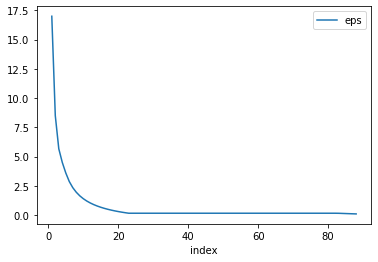

In [19]:
ax = plt.gca()
df.reset_index().plot(kind='line', x='index', y='eps', ax=ax)
plt.show()

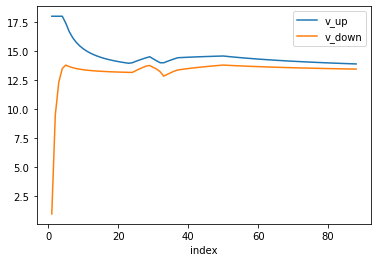

In [20]:
ax = plt.gca()
df.reset_index().plot(kind='line', x='index', y='v_up', ax=ax)
df.reset_index().plot(kind='line', x='index', y='v_down', ax=ax)
plt.show()